# First ICU Prediction using CNN with Word Embeddings

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from collections import OrderedDict
from functools import partial
from sklearn.metrics import *

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from ignite.engine import Events, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

from cnn_classifier.dataset import NoteDataset
from cnn_classifier.model import NoteClassifier
from cnn_classifier.containers import ModelContainer, DataContainer
from cnn_classifier.trainer import IgniteTrainer
from utils.embeddings import PretrainedEmbeddings
from utils.plots import *
from utils.metrics import BinaryAvgMetrics, get_best_model

from utils.splits import set_group_splits, set_group_all_splits
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/cnn'),
 'modeldir': PosixPath('../data/workdir/cnn/models'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'batch_size': 128,
 'min_freq': 3,
 'hidden_dim': 100,
 'dropout_p': 0.1,
 'emb_dropout': 0.1,
 'n_channels': 100,
 'lr': 0.001,
 'wd': 0.0,
 'n_epochs': 10,
 'checkpointer_save_total': 1,
 'emb_path': PosixPath('../pretrained/glove/glove.6B.50d.txt'),
 'emb_sz': 50,
 'checkpointer_prefix': 'glove50_cnn',
 'device': 'cuda:3',
 'checkpointer_name': 'epoch',
 'checkpointer_save_every': 5,
 'early_stop_patience': 10,
 'imminent_threshold': 0.2,
 'discharge_threshold': 0.5,
 'start_seed': 127}

## Functions

In [3]:
def get_sample(df, sample_pct=0.01, with_val=True, seed=None):
  train = df.loc[(df['split']) == 'train'].sample(frac=sample_pct, random_state=seed)
  train.reset_index(inplace=True, drop=True)

  if with_val:
    val = df.loc[(df['split']) == 'val'].sample(frac=sample_pct, random_state=seed)
    val.reset_index(inplace=True, drop=True)
    return pd.concat([train, val], axis=0) 

  return train

In [4]:
def convert_probs(output, thresh):
  y_pred, y = output
  y_pred = (torch.sigmoid(y_pred) > thresh).long()
  return y_pred, y

def predict_proba(clf, x_test):
  return torch.sigmoid(clf(x_test)).detach().numpy()

## CNN Dev

In [5]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df[args.prolonged_stay_cols].copy()

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(75271, 3)


### Imminent ICU Admission

In [6]:
df = set_group_all_splits(ia_df.copy(), 'hadm_id', val_pct=0.1, test_pct=0.1, seed=seed)
dc = DataContainer(df, 'imminent_adm_label', NoteDataset, args.workdir, bs=args.batch_size, with_test=True, min_freq=args.min_freq, create_vec=True, weighted_sampling=True)
itr = iter(dc.train_dl)

In [7]:
pe = PretrainedEmbeddings.from_file(args.emb_path)
pe.make_custom_embeddings(dc.get_vocab_tokens())

classifier = NoteClassifier(args.emb_sz, dc.get_vocab_size(), args.n_channels, args.hidden_dim, dc.n_classes, dropout_p=args.dropout_p, emb_dropout=args.emb_dropout, pretrained=pe.custom_embeddings)
optimizer = optim.Adam(classifier.parameters(), lr=args.lr, weight_decay=args.wd)
reduce_lr = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 1)
loss_fn = nn.BCEWithLogitsLoss()
mc = ModelContainer(classifier, loss_fn, optimizer, reduce_lr)

In [ ]:
x, y = next(itr)
y_pred = classifier(x)
print(loss_fn(y_pred, y))

In [8]:
bce_logits_wrapper = partial(convert_probs, thresh=args.imminent_threshold)
metrics = OrderedDict({ 'loss': Loss(loss_fn)})
ig = IgniteTrainer(mc, dc, args, metrics, log_training=False, early_stop=False)
model_name = ig.run()

Epoch [1/10]: [317/317] 100%|██████████, loss=5.95e-01 [01:36<00:00]


Training loss 0.569 
Validation loss 0.569 


Epoch [2/10]: [317/317] 100%|██████████, loss=4.61e-01 [01:39<00:00]


Training loss 0.477 
Validation loss 0.630 


Epoch [3/10]: [317/317] 100%|██████████, loss=3.87e-01 [01:38<00:00]


Training loss 0.365 
Validation loss 0.572 


Epoch [4/10]: [317/317] 100%|██████████, loss=3.35e-01 [01:40<00:00]


Training loss 0.348 
Validation loss 0.689 


Epoch [5/10]: [317/317] 100%|██████████, loss=3.17e-01 [01:37<00:00]


Training loss 0.285 
Validation loss 0.608 


Epoch [6/10]: [317/317] 100%|██████████, loss=2.82e-01 [01:38<00:00]


Training loss 0.277 
Validation loss 0.700 


Epoch [7/10]: [317/317] 100%|██████████, loss=2.66e-01 [01:38<00:00]


Training loss 0.244 
Validation loss 0.718 


Epoch [8/10]: [317/317] 100%|██████████, loss=2.54e-01 [01:40<00:00]


Training loss 0.244 
Validation loss 0.732 


Epoch [9/10]: [317/317] 100%|██████████, loss=2.51e-01 [01:38<00:00]


Training loss 0.227 
Validation loss 0.758 


Epoch [10/10]: [317/317] 100%|██████████, loss=2.46e-01 [01:38<00:00]


Training loss 0.221 
Validation loss 0.755 


In [9]:
preds = []
probs = []
targs = []
classifier = classifier.cpu()
for x, y in dc.test_dl:
  if len(targs) == 0:
    targs.append(y.numpy())
  else:
    targs[0] = np.append(targs[0], y.numpy(), axis=0)
    
  prob = torch.sigmoid(classifier(x)).detach().numpy()
  if len(probs) == 0:
    probs.append(prob)
  else:
    probs[0] = np.append(probs[0], prob, axis=0)

  pred = (prob > 0.5).astype(np.int64)
  if len(preds) == 0:
    preds.append(pred)
  else:
    preds[0] = np.append(preds[0], pred, axis=0)

prob = np.squeeze(probs[0])
pred = np.squeeze(preds[0])
targ = np.squeeze(targs[0])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, targ, prob, 0.1, 0.9, 25)

In [ ]:
args.imminent_threshold = 0.24
pred = (prob > args.imminent_threshold).astype(np.int64)
cm = confusion_matrix(targ, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(targ, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

## Testing

In [ ]:
dc = DataContainer(df, NoteDataset, args.workdir, bs=args.batch_size, with_test=True,\
                   min_freq=args.min_freq, load_vec=True)

print(dc.get_dataset_size())
print(dc.get_batch_sizes())
print(dc.get_num_batches())

In [ ]:
pe = PretrainedEmbeddings.from_file(args.emb_path)
pe.make_custom_embeddings(dc.get_vocab_tokens())

classifier = NoteClassifier(args.emb_sz, dc.get_vocab_size(), args.n_channels, args.hidden_dim, dc.n_classes,\
                            dropout_p=args.dropout_p, pretrained=pe.custom_embeddings)

state_dict = torch.load(args.modelfile)
classifier.load_state_dict(state_dict);

### Plots

In [ ]:
log = pd.read_csv(args.workdir/'training_log.csv')
log = log[:-1]
log.head()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
log.plot(x='epoch', y=['training_loss', 'validation_loss'], kind='line',
                      title='Training and validation loss', ax=axes[0][0])
log.plot(x='epoch', y=['training_accuracy', 'validation_accuracy'], kind='line',
                      title='Training and validation accuracy', ax=axes[0][1])
log.plot(x='epoch', y=['training_precision', 'validation_precision'], kind='line',
                      title='Training and validation precision', ax=axes[1][0])
log.plot(x='epoch', y=['training_recall', 'validation_recall'], kind='line',
                      title='Training and validation recall', ax=axes[1][1])

### Test set

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
bce_logits_wrapper = partial(convert_probs, thresh=args.bc_threshold)
metrics = OrderedDict({ 'loss': Loss(loss_fn), 'sensitivity': Recall(bce_logits_wrapper),\
                       'ppv': Precision(bce_logits_wrapper)})

In [ ]:
evaluator = create_supervised_evaluator(classifier, metrics=metrics)

@evaluator.on(Events.COMPLETED)
def log_testing_results(engine):
  metrics = engine.state.metrics
  for metric in metrics.keys():
    print(f"{metric} {metrics[metric]:0.3f}")

evaluator.run(dc.test_dl)

### Interpretation

In [10]:
from sklearn.manifold import TSNE

In [11]:
wts = classifier.emb.weight.detach().numpy()
words = list(dc.vectorizer.vocab.idx_token_bidict.values())

In [14]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500)
new_values = tsne_model.fit_transform(wts)

In [15]:
labels = []
tokens = []

In [18]:
x,y = [],[]

In [19]:
for value in new_values:
  x.append(value[0])
  y.append(value[1])

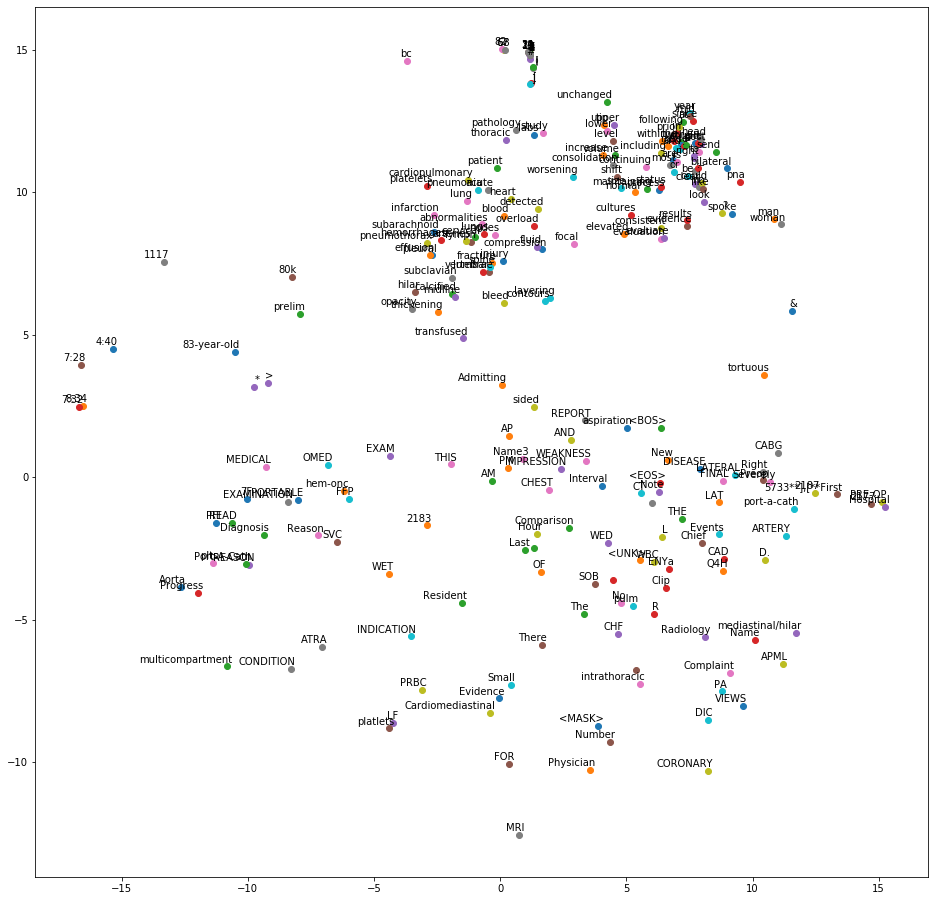

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))
for i in range(len(x[:250])):
  ax.scatter(x[i],y[i])
  ax.annotate(words[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')           

In [ ]:
def tsne_plot(model):
  "Creates and TSNE model and plots it"
  labels = []
  tokens = []

  for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])

  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.show()

In [ ]:
new_values = tsne_model.fit_transform(wts)

In [ ]:
scores = np.linalg.norm(wts, axis=1)
scores /= scores.sum()

In [ ]:
words = list(dc.vectorizer.vocab.idx_token_bidict.values())

In [ ]:
neg_cloud, pos_cloud = get_wordcloud(words, scores, n_words=50)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Delayed')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Imminent')

In [ ]:
# sort weights
emb = classifier.emb.weight.detach()[0]
_, idxs = torch.sort(emb, dim=0, descending=True)
idxs = idxs.numpy().tolist()

In [ ]:
# Top 20 words
print("Influential words in positive class:")
print("--------------------------------------")
for i in range(20):
    print(dc.vectorizer.vocab.lookup_idx(idxs[i]))
    
print("====\n\n\n")

In [ ]:
# Top 20 words
print("Influential words in negative class:")
print("--------------------------------------")
idxs.reverse()
for i in range(20):
    print(dc.vectorizer.vocab.lookup_idx(idxs[i]))
    
print("====\n\n\n")

## Metrics

In [ ]:
# run this if preds.pkl is not generated
targs,preds,probs = [],[],[]

for i in range(4):
  with open(args.workdir/f'preds_{i+1}.pkl', 'rb') as f:
    targs_i = pickle.load(f)
    preds_i = pickle.load(f)
    probs_i = pickle.load(f)
    
  targs += targs_i
  preds += preds_i
  probs += probs_i

with open(args.workdir/'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [ ]:
with open(args.workdir/'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)
  
fnames = [f'glove50_cnn_{seed}_epoch_15.pth' for seed in range(args.start_seed, args.start_seed + 100)]  

In [ ]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam.get_avg_metrics()

In [ ]:
get_best_model(bam, fnames)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Data

In [ ]:
df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df['split'] = 'train'
dc = DataContainer(df, NoteDataset, args.workdir, bs=args.batch_size, with_test=False,\
                   min_freq=args.min_freq, create_vec=True, weighted_sampling=True)

pe = PretrainedEmbeddings.from_file(args.emb_path)
pe.make_custom_embeddings(dc.get_vocab_tokens())

classifier = NoteClassifier(args.emb_sz, dc.get_vocab_size(), args.n_channels, args.hidden_dim, dc.n_classes,\
                            dropout_p=args.dropout_p, emb_dropout=args.emb_dropout,\
                            pretrained=pe.custom_embeddings)

optimizer = optim.Adam(classifier.parameters(), lr=args.lr, weight_decay=args.wd)
reduce_lr = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 1)
loss_fn = nn.BCEWithLogitsLoss()

mc = ModelContainer(classifier, loss_fn, optimizer, reduce_lr)

In [ ]:
metrics = OrderedDict({ 'loss': Loss(loss_fn)})
ig = IgniteTrainer(mc, dc, args, metrics, log_training=False, early_stop=False)
ig.run()

In [ ]:
dc.train_ds.save_vectorizer(args.workdir)

In [ ]:
test_ds = NoteDataset.load_data_and_vectorizer(df, dc.vectorizer)
test_dl = DataLoader(test_ds, len(test_ds))

In [ ]:
state_dict = torch.load(args.workdir/'models/glove50_cnn_epoch_15.pth', map_location='cpu')

In [ ]:
with open(args.workdir/'full_data_model.pkl', 'wb') as f:
  pickle.dump(state_dict, f)
  pickle.dump(dc.train_ds.vectorizer,f )

In [ ]:
classifier.load_state_dict(state_dict);

In [ ]:
x, y = next(iter(test_dl))

In [ ]:
x = x.to('cpu')
classifier = classifier.to('cpu')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pred = classifier(x)

In [ ]:
torch.sigmoid(clf(x_test)).detach().numpy()

In [ ]:
prob = predict_proba(classifier, x)

In [ ]:
prob.shape